In [1]:
import numpy as np
import pandas as pd
import glob
import pyvtk
from sklearn.decomposition import PCA
import vtk
import matplotlib.pyplot as plt
from scipy import interpolate
import datetime
from sklearn.model_selection import train_test_split
import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
import geomstats.backend as gs
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import DiscreteCurves

from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length

mpl.rc('image', cmap='PuOr')
plt.set_cmap('jet')

ROOT = "D:\\!BraVa_src\\Brava\\splined_major\\reversed_distal\\resampling\\attribute\\"
left= ROOT + "BG0020_Left.vtk"
right=ROOT + "BG0020_Right.vtk"



INFO: Using numpy backend


<Figure size 640x480 with 0 Axes>

`Reflect`は、すでに`.vtk`作成の段階で行い、下のcoordinatesのplotからも左右ほぼ一致に見えてきたが、X-Z平面にalignしていないため、微妙に差が残ったかも

files exist


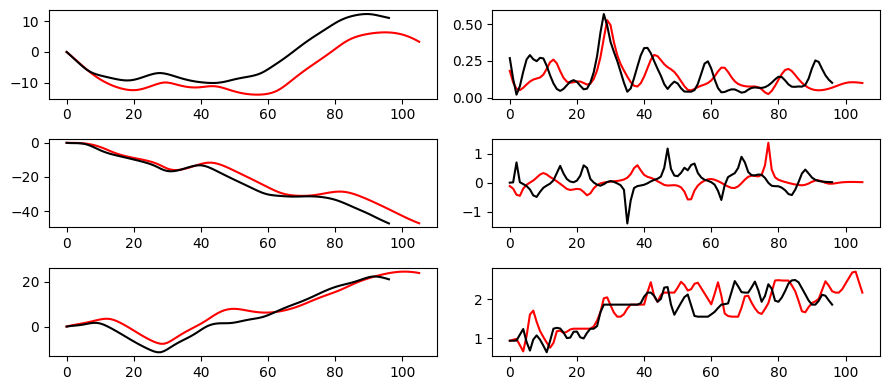

In [2]:
import os

if os.path.exists(left) and os.path.exists(right): 
    print ("files exist")
    lt_pts, lt_Curv, lt_Tors, lt_r, lt_Abscissas, lt_PTN = GetMyVtk(left)
    rt_pts, rt_Curv, rt_Tors, rt_r, rt_Abscissas, rt_PTN = GetMyVtk(right)

    fig = plt.figure(dpi=100, figsize=(9,4))
    ax1 = fig.add_subplot(321)
    ax1.plot(range(len(lt_pts)), lt_pts[:,0], c="r")
    ax1.plot(range(len(rt_pts)), rt_pts[:,0], c="black")
    #ax1.plot(range(len(rt_pts)), -rt_pts[:,0], c="b", linestyle=":")
    ax2 = fig.add_subplot(323)
    ax2.plot(range(len(lt_pts)), lt_pts[:,1], c="r")
    ax2.plot(range(len(rt_pts)), rt_pts[:,1], c="black")
    #ax2.plot(range(len(rt_pts)), -rt_pts[:,1], c="b", linestyle=":")
    ax3 = fig.add_subplot(325)
    ax3.plot(range(len(lt_pts)), lt_pts[:,2], c="r")
    ax3.plot(range(len(rt_pts)), rt_pts[:,2], c="black")
    #ax3.plot(range(len(rt_pts)), -rt_pts[:,2], c="b", linestyle=":")

    ax4 = fig.add_subplot(322)
    ax4.plot(range(len(lt_pts)), lt_Curv, c="r")
    ax4.plot(range(len(rt_pts)), rt_Curv, c="black")
    #ax3.plot(range(len(rt_pts)), -rt_pts[:,2], c="b", linestyle=":")

    ax5 = fig.add_subplot(324)
    ax5.plot(range(len(lt_pts)), lt_Tors, c="r")
    ax5.plot(range(len(rt_pts)), rt_Tors, c="black")
    #ax3.plot(range(len(rt_pts)), -rt_pts[:,2], c="b", linestyle=":")

    ax6 = fig.add_subplot(326)
    ax6.plot(range(len(lt_pts)), lt_r, c="r")
    ax6.plot(range(len(rt_pts)), rt_r, c="black")
    #ax3.plot(range(len(rt_pts)), -rt_pts[:,2], c="b", linestyle=":")

    fig.tight_layout()

    plt.show()

else:
    print ("????")
    print (left)
    print (right)


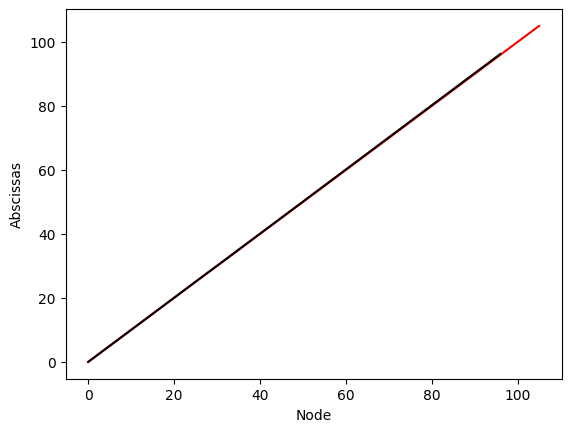

In [3]:
fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(111)
ax1.plot(range(len(lt_pts)), lt_Abscissas, c="r")
ax1.plot(range(len(rt_pts)), rt_Abscissas, c="black")
ax1.set_ylabel("Abscissas")
ax1.set_xlabel("Node")

plt.show()

Extrapolate short vessels.

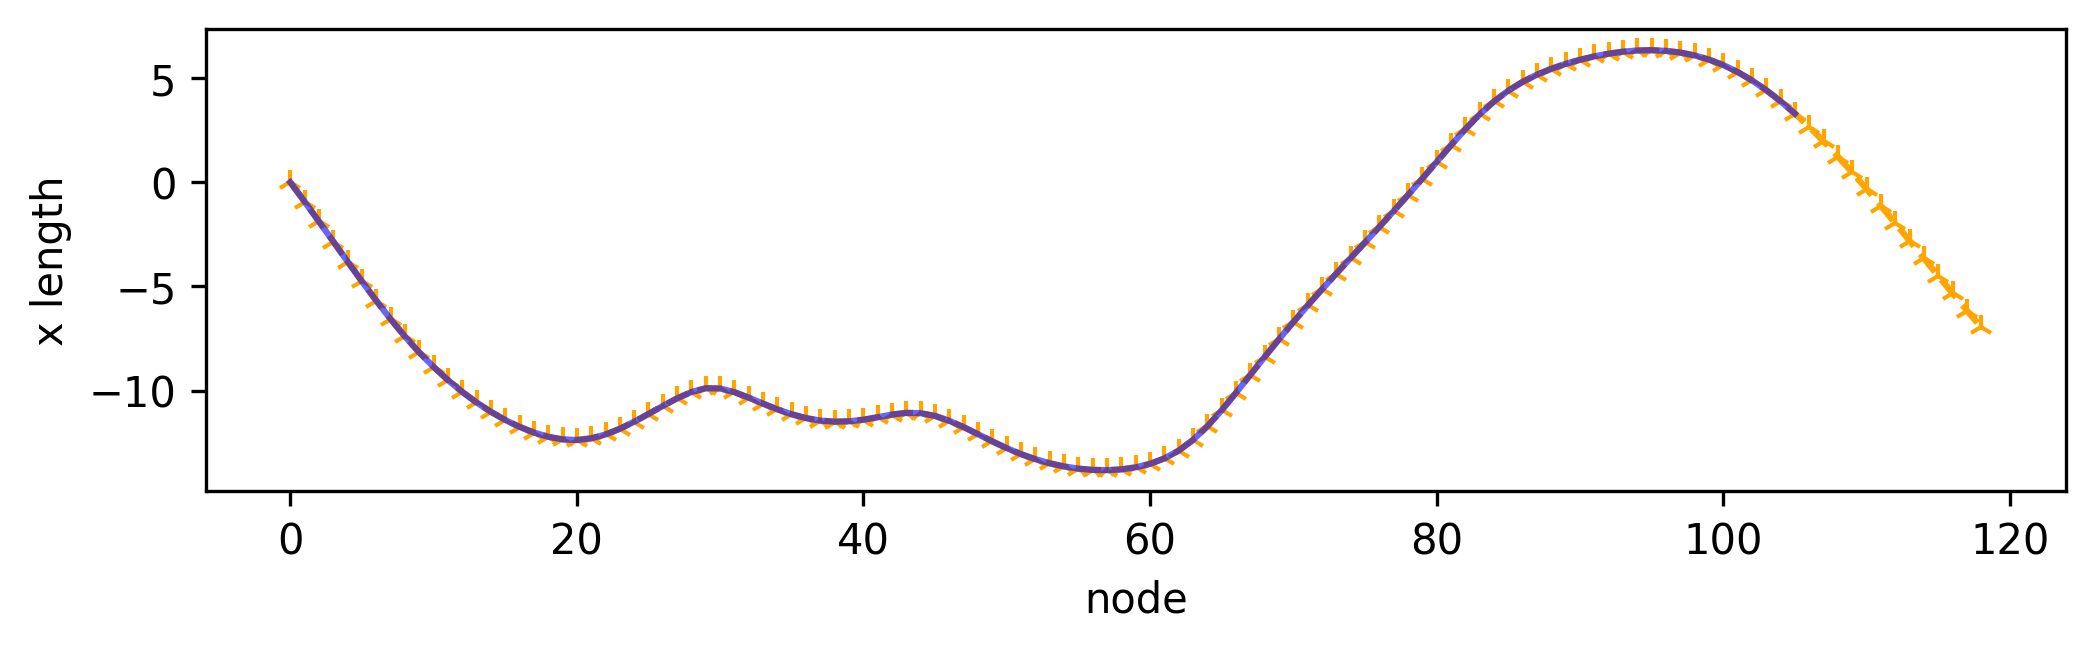

In [4]:
ep_length = 119
x = range(len(lt_pts))
y = lt_pts[:]
f = interpolate.CubicSpline(x, y, extrapolate=None)
g = interpolate.CubicSpline(x, y, extrapolate='Periodic')
h = interpolate.CubicSpline(x, y, extrapolate=1)
z = range(ep_length)
fig = plt.figure(dpi=300, figsize=(8,2))
#plt.plot(z, f(z)[:,0], c="b", linestyle = "--")
#plt.plot(z, g(z)[:,0], c="green", linestyle = "--")
plt.plot(z, h(z)[:,0], c="orange", linestyle = "--", marker="2")
plt.plot(x,y[:,0],c="blue", alpha=0.6)
plt.xlabel("node")
plt.ylabel("x length")
#plt.axis('off')
plt.show()

In [5]:
# 平均を求める。
files = glob.glob(ROOT + "*.vtk")
print (len(files),"files in total.")

extrapolated_pts = []
interpolated_pts = []
raw_pts = []
pt_attributes = []
original_length_rec = []

max_pt_length = 0
for i in range (len(files)):
    pts, _, _, _, _, _ = GetMyVtk(files[i])
    max_pt_length = max(max_pt_length, len(pts))
    original_length_rec.append(len(pts))



interpolated_pt_r = np.zeros((len(files),max_pt_length))
extrapolated_pt_r = np.zeros((len(files),max_pt_length))
# print ("!!",extrapolated_pt_r.shape,"!!", max_pt_length)

z = range(max_pt_length)


print ("max length:", max_pt_length)
for i in range(len(files)):
    # print ("!!!!!!!", i)
    pts, Curv, Tors, Radius, Abscissas, PTN = GetMyVtk(files[i])
    raw_pts.append(pts) #raw_ptsはnp.array化できない！
    ##############################
    # 形状パラメータを画像で出力
    fig = plt.figure(dpi=300,figsize=(10,3))
    ax = fig.add_subplot(111)
    lns1 = ax.plot(Abscissas, Curv,label="curve", color="red")
    ax2 = plt.twinx(ax)
    lns2 = ax2.plot(Abscissas, Tors,label="torsion", linestyle=":", color="dimgray")
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    plt.savefig(".\\curv_tors\\{}.png".format(files[i].split("\\")[-1]))
    plt.close()
    ##############################
    new_pts = []
    int_pts = []
    x = range(len(pts))
    z2 = np.linspace(0,len(pts), max_pt_length)

    #############################################
    #　　　　　　　　座標外挿(f)                 #
    #############################################
    f = interpolate.CubicSpline(x, pts, extrapolate=None)
    new_pts = np.array(f(z))
    #############################################
    #　　　　　　　　座標内挿(g)                 #
    #############################################   
    g = interpolate.CubicSpline(x,pts)
    int_pts = np.array(g(z2))

    #############################################
    #　　　　　　　　半径外挿(g)                 #
    #############################################   
    extrapolated_pt_r[i, 0:len(Curv)] = Curv
    
    #############################################
    #　　　　　　　　半径内挿(g)                 #
    #############################################   
    h=interpolate.CubicSpline(x, Curv)

    if len(pts) < max_pt_length:
        interpolated_pt_r[i] = h(z2)
    else:
        interpolated_pt_r[i] = Curv

    
    pt_attributes.append([Curv, Tors, Radius, Abscissas, PTN])
    extrapolated_pts.append(new_pts)
    interpolated_pts.append(int_pts)


extrapolated_pts = np.array(extrapolated_pts)
interpolated_pts = np.array(interpolated_pts)



np.save("./extrapolated_pts.npy", extrapolated_pts)
np.save("./interpolated_pts.npy", interpolated_pts)

# plt.plot(interpolated_pts[0,:,0])
# plt.plot(interpolated_pt_r[0,:])
    

104 files in total.
max length: 119


# Procrustes.

- code, and general one: https://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy

# Mean Shape (Extrapolation)

(119, 3)


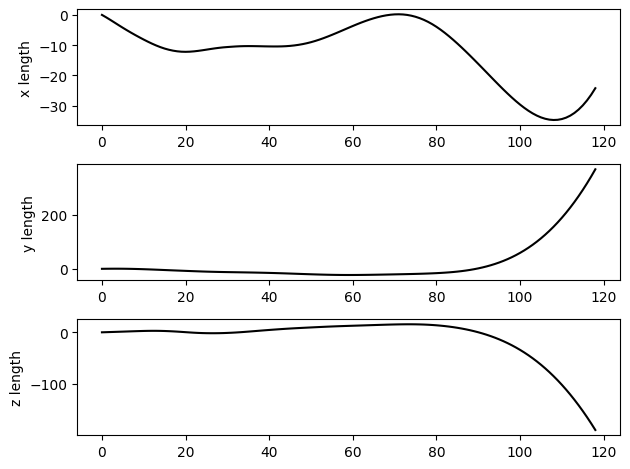

In [6]:
ex_mean_shape = np.zeros((max_pt_length, 3))
print (ex_mean_shape.shape)

for i in range(max_pt_length):
    for j in range(ex_mean_shape.shape[1]): # 0,1,2
        ex_mean_shape[i,j] = np.sum(extrapolated_pts[:,i,j])/(extrapolated_pts.shape[0])

fig = plt.figure(dpi=100)

ax1 = fig.add_subplot(311)
ax1.plot(range(max_pt_length), ex_mean_shape[:,0], c="black")
#ax1.plot(range(len(lt_pts)), lt_pts[:,0], c="dimgray", linestyle="--")
ax1.set_ylabel("x length")
ax2 = fig.add_subplot(312)
ax2.plot(range(max_pt_length), ex_mean_shape[:,1], c="black")
#ax2.plot(range(len(lt_pts)), lt_pts[:,1], c="dimgray", linestyle="--")
ax2.set_ylabel("y length")
ax3 = fig.add_subplot(313)
ax3.plot(range(max_pt_length), ex_mean_shape[:,2], c="black")
ax3.set_ylabel("z length")
#ax3.plot(range(len(lt_pts)), lt_pts[:,2], c="dimgray", linestyle="--")

fig.tight_layout()

# Mean shape (interpolation)

(119, 3)


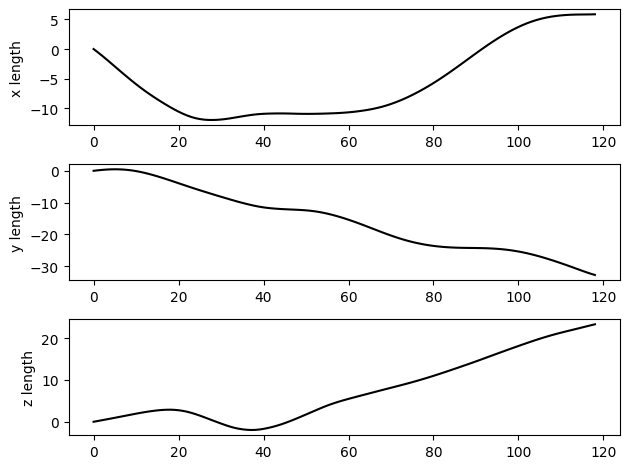

In [7]:
in_mean_shape = np.zeros((max_pt_length, 3))
print (in_mean_shape.shape)

for i in range(max_pt_length):
    for j in range(in_mean_shape.shape[1]): # 0,1,2
        in_mean_shape[i,j] = np.sum(interpolated_pts[:,i,j])/(interpolated_pts.shape[0])

fig = plt.figure(dpi=100)

ax1 = fig.add_subplot(311)
ax1.plot(range(max_pt_length), in_mean_shape[:,0], c="black")
#ax1.plot(range(len(rt_pts)), rt_pts[:,0], c="dimgray", linestyle="--")
ax1.set_ylabel("x length")
ax2 = fig.add_subplot(312)
ax2.plot(range(max_pt_length), in_mean_shape[:,1], c="black")
#ax2.plot(range(len(rt_pts)), rt_pts[:,1], c="dimgray", linestyle="--")
ax2.set_ylabel("y length")
ax3 = fig.add_subplot(313)
ax3.plot(range(max_pt_length), in_mean_shape[:,2], c="black")
#ax3.plot(range(len(rt_pts)), rt_pts[:,2], c="dimgray", linestyle="--")
ax3.set_ylabel("z length")

fig.tight_layout()

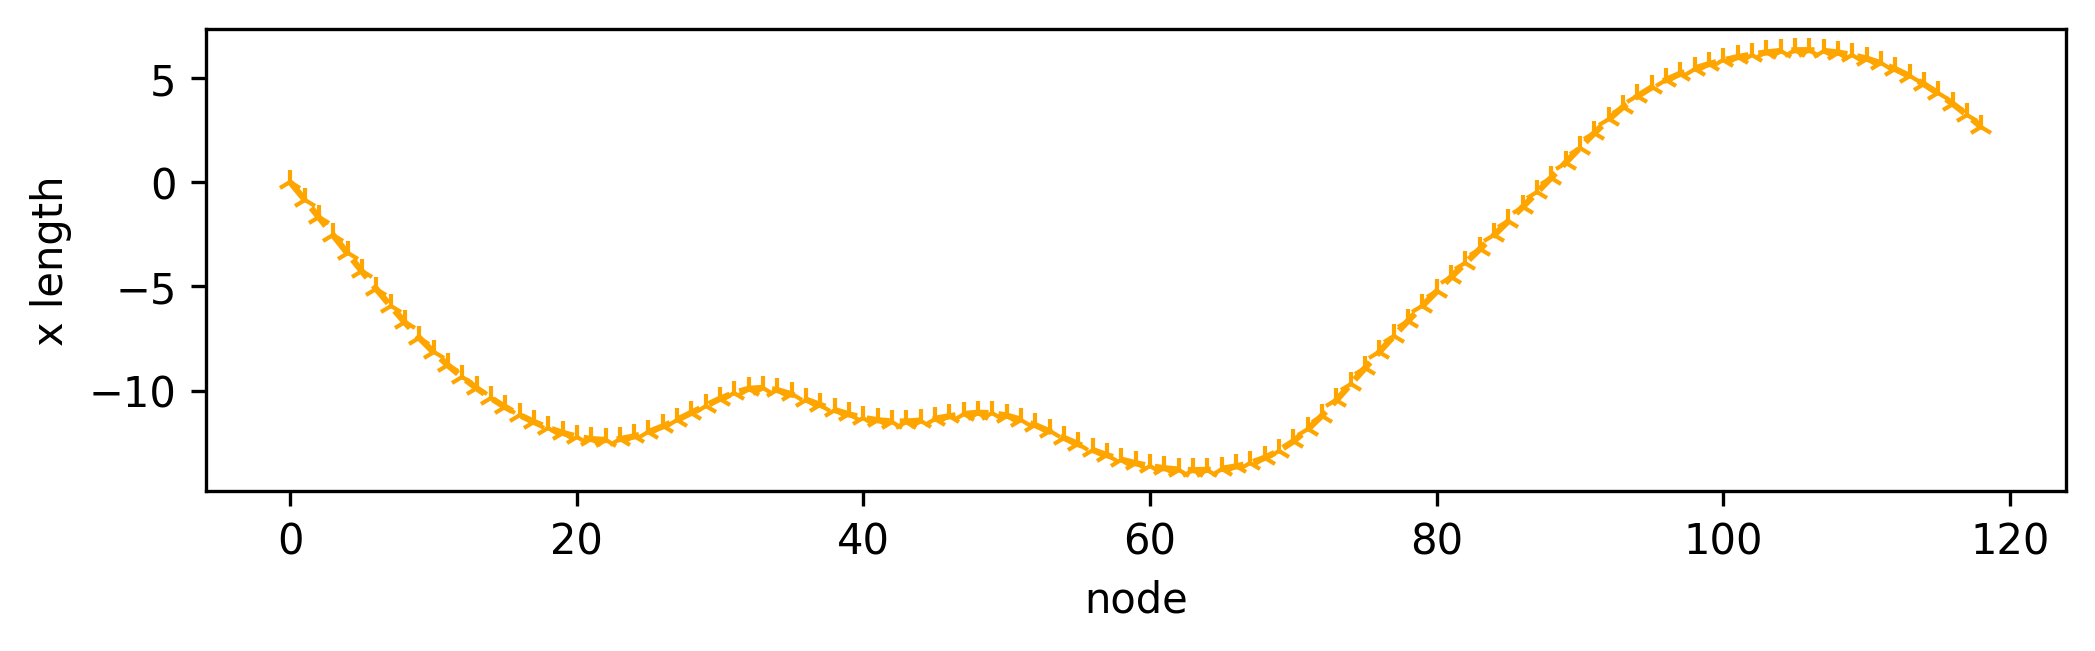

6


In [8]:
fig = plt.figure(dpi=300, figsize=(8,2))
temp =interpolated_pts[6]
plt.plot(range(len(temp)), temp[:,0], c="orange", linestyle = "--", marker="2")
#plt.plot(x,y[:,0],c="blue", alpha=0.6)
plt.xlabel("node")
plt.ylabel("x length")
#plt.axis('off')
plt.show()
for f in range(len(files)):
    if 'BG0020_Left.vtk' in files[f]:
        print (f)

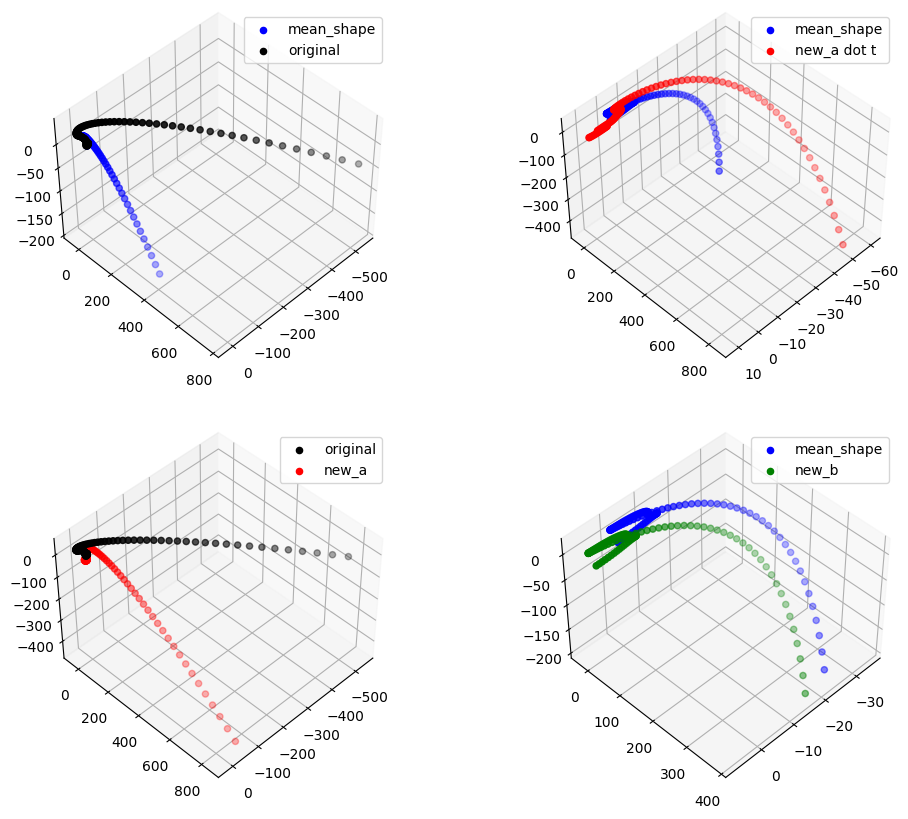

In [9]:
from scipy import linalg
from procrustes import orthogonal, rotational, generic, generalized


idx = 50
v1 = 45
v2=45
weight_array = np.zeros(max_pt_length)
for i in range(original_length_rec[idx]):
    weight_array[i] = 1
result_rot = rotational(extrapolated_pts[idx,:,:], ex_mean_shape, translate=True, scale=False, weight=weight_array)
# result_rot = generic(extrapolated_pts[i,:,:], mean_shape, translate=True, scale=False, weight=weight_array)
at = np.dot(result_rot.new_a, result_rot.t)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter(xs=ex_mean_shape[:, 0], ys=ex_mean_shape[:, 1], zs=ex_mean_shape[:, 2],
            marker="o", color="blue", s=20, label="mean_shape")
ax.scatter(xs=extrapolated_pts[idx, :, 0], ys=extrapolated_pts[idx, :, 1], zs=extrapolated_pts[idx, :, 2],
            marker="o", color="black", s=20, label="original")
ax.legend()
ax.view_init(v1, v2)

ax2 = fig.add_subplot(2, 2, 2, projection='3d')



ax2.scatter(xs=ex_mean_shape[:, 0], ys=ex_mean_shape[:, 1], zs=ex_mean_shape[:, 2],
            marker="o", color="blue", s=20, label="mean_shape")
ax2.scatter(xs=at[:, 0], ys=at[:, 1], zs = at[:, 2],
            marker="o", color="red", s=20, label="new_a dot t")
ax2.legend()
ax2.view_init(v1, v2)

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter(xs=extrapolated_pts[idx, :, 0], ys=extrapolated_pts[idx, :, 1], zs=extrapolated_pts[idx, :, 2],
            marker="o", color="black", s=20, label="original")
ax3.scatter(xs=at[:, 0], ys=at[:, 1], zs = at[:, 2],
            marker="o", color="red", s=20, label="new_a")
ax3.legend()
ax3.view_init(v1, v2)

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(xs=ex_mean_shape[:, 0], ys=ex_mean_shape[:, 1], zs=ex_mean_shape[:, 2],
            marker="o", color="blue", s=20, label="mean_shape")
ax4.scatter(xs=result_rot.new_b[:, 0], ys=result_rot.new_b[:, 1], zs=result_rot.new_b[:, 2],
            marker="o", color="green", s=20, label="new_b")
ax4.legend()
ax4.view_init(v1, v2)



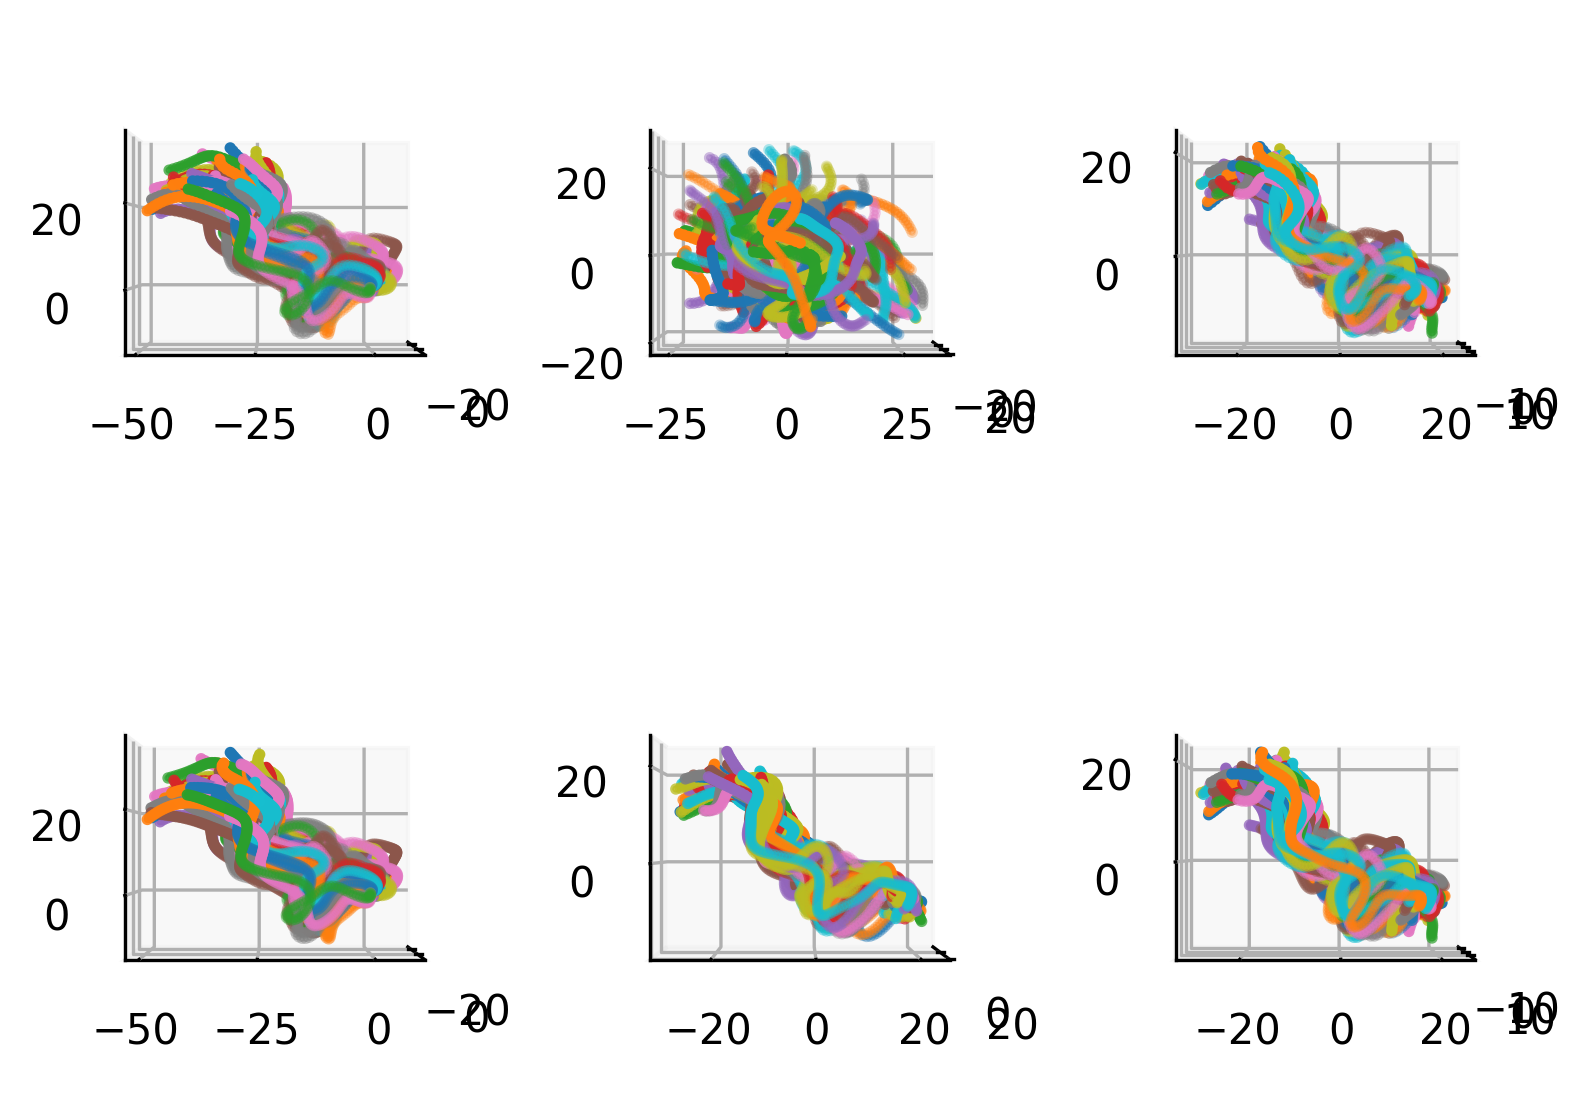

in err: 219909.90249487816
ex err 2761155807.8863206


In [10]:
ex_align_pts = []
in_align_pts = []

fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(2,3, 1, projection='3d')
ax2 = fig.add_subplot(2,3, 2, projection='3d')
ax3 = fig.add_subplot(2,3, 3, projection='3d')
ax4 = fig.add_subplot(2,3, 4, projection='3d')
ax5 = fig.add_subplot(2,3, 5, projection='3d')
ax6 = fig.add_subplot(2,3, 6, projection='3d')

v1=0
v2=0

ex_err = 0
in_err = 0


for j in range(0, len(extrapolated_pts)):
    weight_array = np.zeros(max_pt_length)
    cutdown = original_length_rec[j]
    for i in range(original_length_rec[j]):
        weight_array[i] = 1
    #ex_result_rot = orthogonal(extrapolated_pts[j,:,:], ex_mean_shape, translate=True, scale=False, weight=weight_array)
    ex_result_rot = rotational(extrapolated_pts[j,:,:], ex_mean_shape, translate=True, scale=False, weight=weight_array)
    ex_err = ex_err + ex_result_rot.error
    in_result_rot = rotational(interpolated_pts[j,:,:], in_mean_shape, translate=True, scale=False)
    in_err = in_err + in_result_rot.error
    #result_rot = rotational(extrapolated_pts[j,:cutdown,:], mean_shape[:cutdown,:], translate=True, scale=False)


    ex_at = np.dot(ex_result_rot.new_a, ex_result_rot.t)
    in_at = np.dot(in_result_rot.new_a, in_result_rot.t)
    # align_pts.append(at)
    ex_align_pts.append(ex_result_rot.new_a)
    in_align_pts.append(in_result_rot.new_a)
    # print (at.shape)
    ax1.scatter(xs=extrapolated_pts[j, :cutdown, 0], ys=extrapolated_pts[j, :cutdown, 1], zs=extrapolated_pts[j, :cutdown, 2],
            marker="o", s=3, label="original")
    ax2.scatter(xs=ex_at[:cutdown,0], ys=ex_at[:cutdown,1], zs=ex_at[:cutdown,2], 
            marker="o", s=3, label="procrustes")
    ax3.scatter(xs=ex_result_rot.new_a[:cutdown,0], ys=ex_result_rot.new_a[:cutdown,1], zs=ex_result_rot.new_a[:cutdown,2], 
            marker="o", s=3, label="new_a")
    ax4.scatter(xs=interpolated_pts[j, :, 0], ys=interpolated_pts[j, :, 1], zs=interpolated_pts[j, :, 2],
            marker="o", s=3, label="original")
    ax5.scatter(xs=in_at[:,0], ys=in_at[:,1], zs=in_at[:,2], 
            marker="o", s=3, label="procrustes")
    ax6.scatter(xs=in_result_rot.new_a[:,0], ys=in_result_rot.new_a[:,1], zs=in_result_rot.new_a[:,2], 
            marker="o", s=3, label="new_a")


            
    ax1.view_init(v1, v2)
    ax2.view_init(v1, v2)
    ax3.view_init(v1, v2)
    ax4.view_init(v1, v2)
    ax5.view_init(v1, v2)
    ax6.view_init(v1, v2)
    
plt.show()
ex_align_pts = np.array(ex_align_pts)
in_align_pts = np.array(in_align_pts)

print ("in err:", in_err)
print ("ex err", ex_err)

# 全体を同じサイズまでScalingして、1mm間隔でresampling

In [11]:
# coords(df):
# [[x0,y0,z0], [x1,y1,z1],...]

# scalarAttribute(list):
# [['MaximumInscribedSphereRadius', 'float', pandas.Series]]

# fieldAttribute(list):
#  ['Curvature', 'float',pandas.Series],
#  ['Torsion', 'float',pandas.Series]]


def makeVtkFile(savePath, coords, scalarAttributes, fieldAttributes):
    v = open(savePath, "w+")
    v.write("# vtk DataFile Version 2.0\nVessel Segment\nASCII\nDATASET POLYDATA\nPOINTS {} float\n".format(len(coords)))
    for i in range(len(coords)):
        v.write("{} {} {}\n".format(coords[i,0], coords[i,1], coords[i,2]))

    v.write("LINES {} {}\n".format(1, len(coords)+1))
    v.write("{}".format(len(coords)))
    for i in range(len(coords)):
        v.write(" {}".format(i))
    v.write("\n")
    
    #####################################
    #for i in new_LINES:                #
    #    v.write("{} ".format(len(i)))  #
    #    for j in range(len(i)):        #
    #        v.write("{} ".format(i[j]))#
    #    v.write("\n")                  #
    #####################################

    ####################################
    #        scalar Attributes         #
    ####################################

    if len(scalarAttributes) > 0:
        v.write("POINT_DATA {}\n".format(len(coords)))
    else: 
        return

    for i in range(len(scalarAttributes)):
        v.write("SCALARS {} {}\n".format(scalarAttributes[i][0], scalarAttributes[i][1]))
        v.write("LOOKUP_TABLE default\n")
        for j in range(len(coords)):
                v.write("{}\n".format(scalarAttributes[i][2][j]))

    ####################################
    #         field Attributes         #
    ####################################

    if len(fieldAttributes) > 0:
        v.write("FIELD FieldData {}\n".format(len(fieldAttributes)))
    else: 
        return

    for i in range(len(fieldAttributes)):
        v.write("{} 1 {} {}\n".format(fieldAttributes[i][0], len(coords), fieldAttributes[i][1]))
        # v.write("LOOKUP_TABLE default\n")
        for j in range(len(coords)):
                v.write("{}\n".format(fieldAttributes[i][2][j]))

    v.close()

print ("last output:",datetime.datetime.now())


def measure_length(v):
    l = 0
    for node_idx in range(1, len(v)):
        dl = np.linalg.norm(v[node_idx][0:3]-v[node_idx-1][0:3])
        l = l+dl
    return l

last output: 2022-12-20 10:47:51.460120


In [12]:
mean_length = measure_length(in_mean_shape)
print ("mean shape length:", mean_length)

for i in range(len(raw_pts)):
    saveDir = ".\\scaling\\"
    if os.path.exists(saveDir) != True:
        os.mkdir(saveDir)
    savePath = saveDir + files[i].split("\\")[-1] 
    coords = raw_pts[i]
    Curv, Tors, Radius, Abscissas, PTN = pt_attributes[i]
    mag = measure_length(coords)/measure_length(in_mean_shape)
    scaled_length = measure_length(coords/mag)
    scaled = coords/mag
    if abs(scaled_length - mean_length)>1:
        print ("!!!!!!", i, files[i], scaled - mean_length)
    scalarAttributes = [['MaximumInscribedSphereRadius', 'float', Radius]]
    fieldAttributes = [['Curvature', 'float',Curv],
                    ['Torsion', 'float',Tors]]
    # makeVtkFile(savePath, scaled, scalarAttributes, fieldAttributes)
    

mean shape length: 63.92013307821088


# scaled形状を読み込む

In [13]:
scaled_files = (glob.glob(".\\scaling\\resamp_attr_ascii\\*.vtk"))
#print (scaled_files)
scaled_r = []
scaled_pts = []
scaled_PTN = []
for i in range(len(scaled_files)): 
    pts, Curv, Tors, Radius, Abscissas, PTN = GetMyVtk(scaled_files[i])
    if len(pts) != 64:
        print (len(pts), scaled_files[i])
    scaled_pts.append(pts)
    scaled_r.append(Radius)
    scaled_PTN.append(PTN)
scaled_pts = np.array(scaled_pts)
scaled_r = np.array(scaled_r)
scaled_PTN = np.array(scaled_PTN)

np.save("./scaled_pts.npy", scaled_pts)


# scaled平均形状を求める

(119, 3)


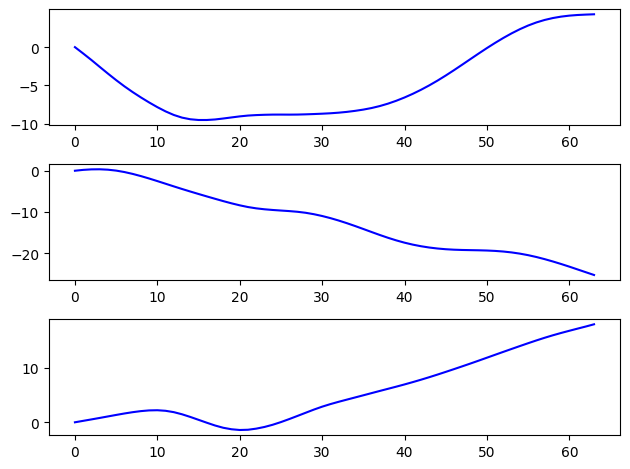

In [14]:
scaled_nodes = len(scaled_pts[0])

scaled_mean_shape = np.zeros((len(scaled_pts[0]), 3))
print (in_mean_shape.shape)

for i in range(scaled_nodes):
    for j in range(scaled_mean_shape.shape[1]): # 0,1,2
        scaled_mean_shape[i,j] = np.sum(scaled_pts[:,i,j])/scaled_pts.shape[0]

fig = plt.figure(dpi=100)

ax1 = fig.add_subplot(311)
ax1.plot(range(scaled_nodes), scaled_mean_shape[:,0], c="blue")
#ax1.plot(range(len(rt_pts)), rt_pts[:,0], c="dimgray", linestyle="--")
ax2 = fig.add_subplot(312)
ax2.plot(range(scaled_nodes), scaled_mean_shape[:,1], c="blue")
#ax2.plot(range(len(rt_pts)), rt_pts[:,1], c="dimgray", linestyle="--")
ax3 = fig.add_subplot(313)
ax3.plot(range(scaled_nodes), scaled_mean_shape[:,2], c="blue")
#ax3.plot(range(len(rt_pts)), rt_pts[:,2], c="dimgray", linestyle="--")

fig.tight_layout()

# scaling + coordinate base PCA

In [15]:
cmap = plt.get_cmap("PuOr")

aligned_scaled_pts = []
for i in range(len(scaled_pts)):
    result_rot = rotational(scaled_pts[i,:,:], scaled_mean_shape, translate=True, scale=False)
    aligned_scaled_pts.append(result_rot.new_a)
aligned_scaled_pts = np.array(aligned_scaled_pts)

scaled_quad = []
for i in range(scaled_pts.shape[0]):
    scaled_quad.append(np.append(aligned_scaled_pts[i,:,:].flatten('F'), scaled_r[i]))
    # print (extrapolated_quad)
scaled_quad=np.array(scaled_quad)

################################
#      numpyだけでPCA実装       #
################################
cov_mat = np.cov(scaled_quad.T)

print (cov_mat.shape)
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)
################################
#      numpyだけでPCA実装       #
################################



(256, 256)


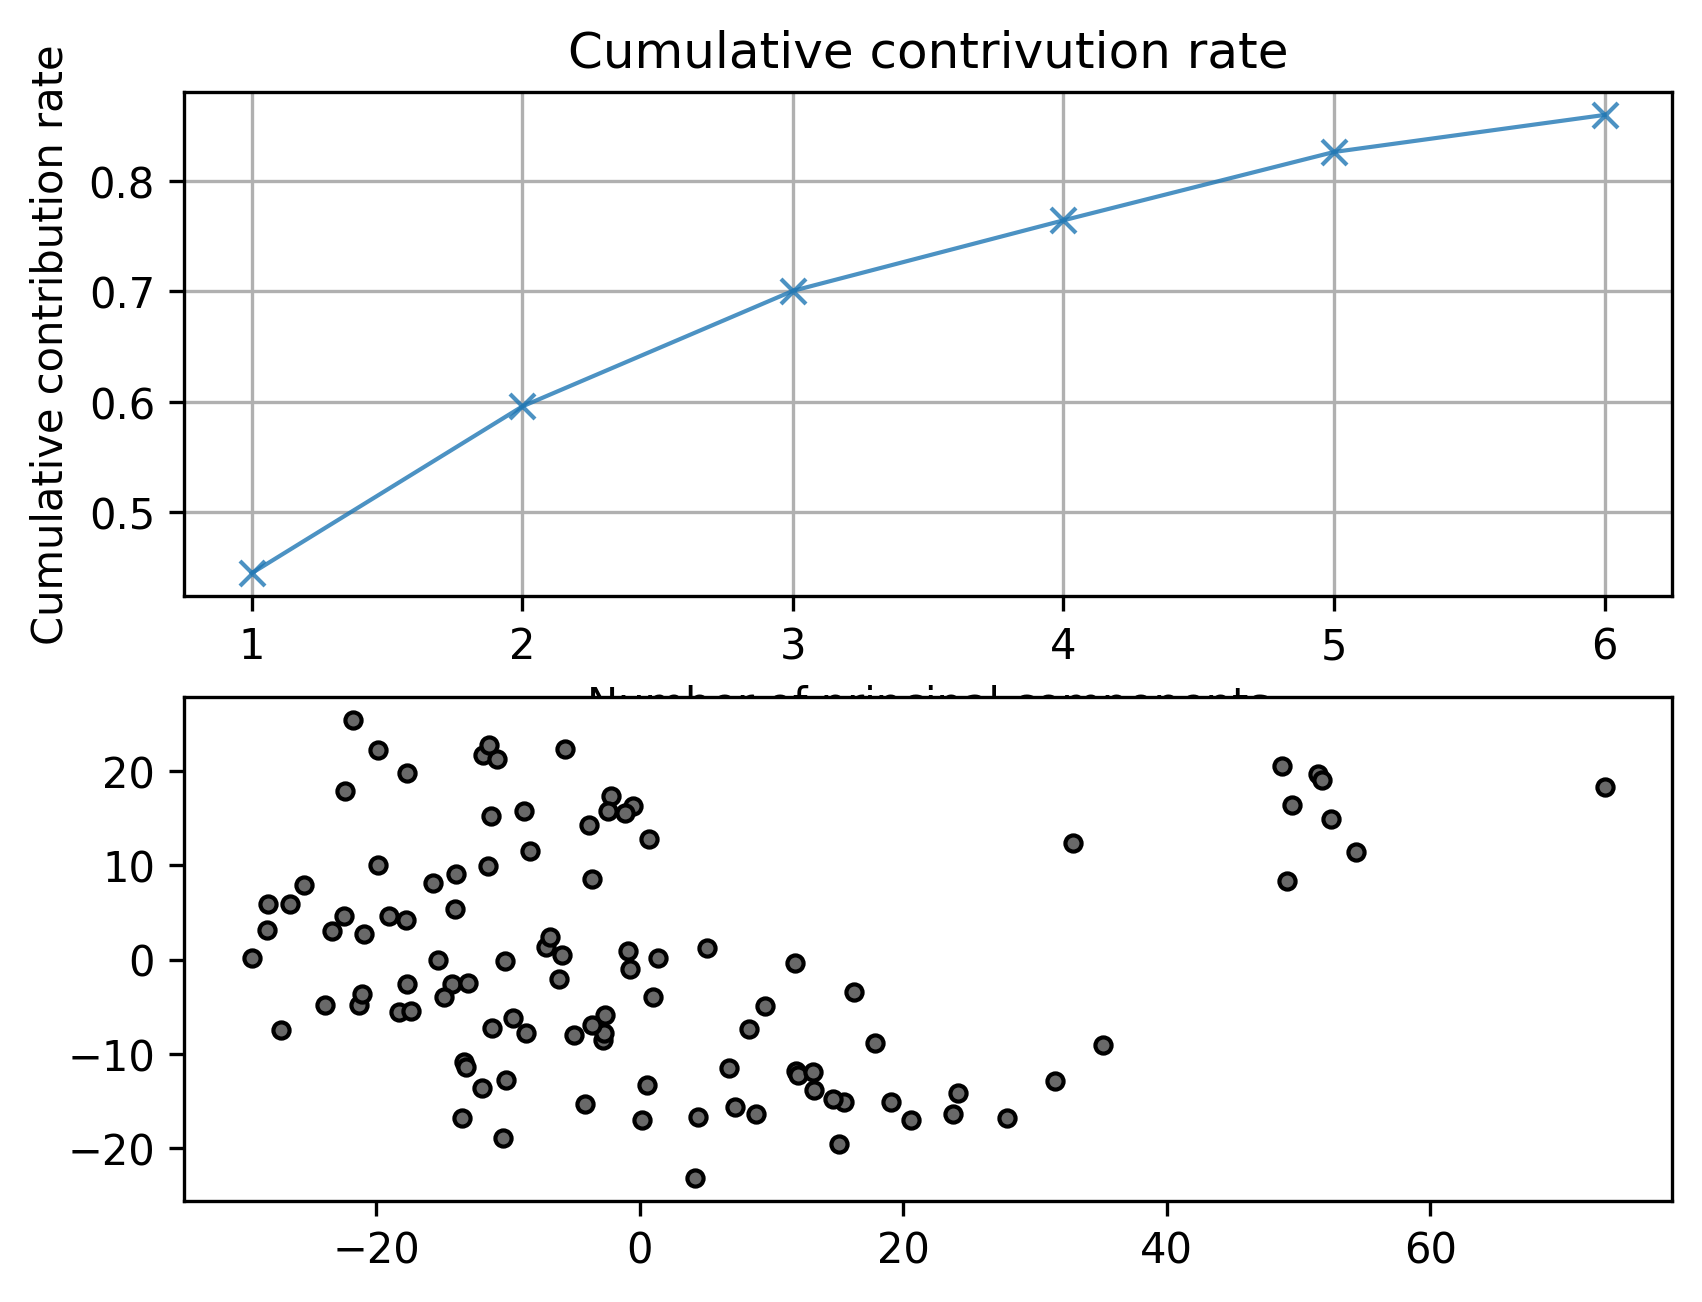

In [16]:
CROSS_VALID = 0


for j in [16]:
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(211)
    sc_pca = PCA(n_components=6)
    if CROSS_VALID == 1:
        scaled_quad_train,scaled_quad_valid = train_test_split(scaled_quad, test_size=0.1, random_state=j) 
        sc_result = sc_pca.fit_transform(scaled_quad_train)
        sc_valid_result = sc_pca.transform(scaled_quad_valid)
    else:
        scaled_quad_train = scaled_quad
        sc_result = sc_pca.fit_transform(scaled_quad_train)
        sc_valid_result = sc_pca.transform(scaled_quad_train)

    cumsum = list(np.cumsum(sc_pca.explained_variance_ratio_))
    ax.plot(range(1, len(cumsum)+1),cumsum, "-x",alpha=0.8, linewidth=1)
    #ax.set_xticks([])
    ax.set_xlabel("Number of principal components")
    ax.set_ylabel("Cumulative contribution rate")
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    ax.set_title("Cumulative contrivution rate")
    ax.grid()

    ax2 = fig.add_subplot(212)
    for i in range(len(sc_result)):
        ax2.scatter(sc_result[i,0],sc_result[i,1],
                color = "dimgray", 
                alpha=1, 
                edgecolors="black", 
                linewidths=1, s=15)
        #plt.text(x=sc_result[i,0],y=sc_result[i,1],
                #s=files[i].split("\\")[-1].split(".")[0],
                #alpha=0.45)
    if CROSS_VALID == 1:
        for i in range(len(sc_valid_result)):
            ax2.scatter(sc_valid_result[i,0],sc_valid_result[i,1],
            color = "dimgray", 
            alpha=1, 
            edgecolors="black", 
            linewidths=1, s=15)

scaled_mean_shape[:,0] = sc_pca.mean_[:64]
scaled_mean_shape[:,1] = sc_pca.mean_[64:128]
scaled_mean_shape[:,2] = sc_pca.mean_[128:192]


# Cubic Spline EXTRApolation + coordinate based PCA
https://procrustes.readthedocs.io/_/downloads/en/latest/pdf/

(104, 476)


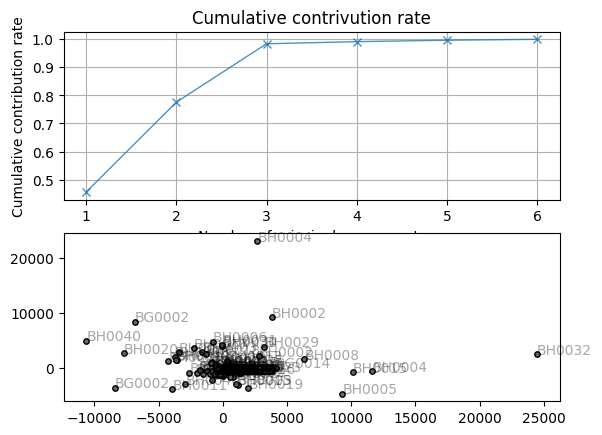

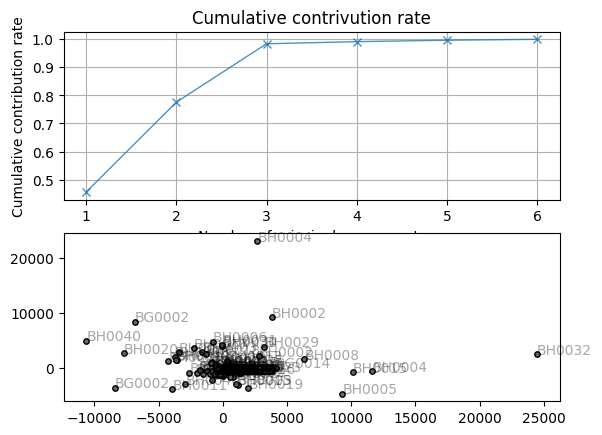

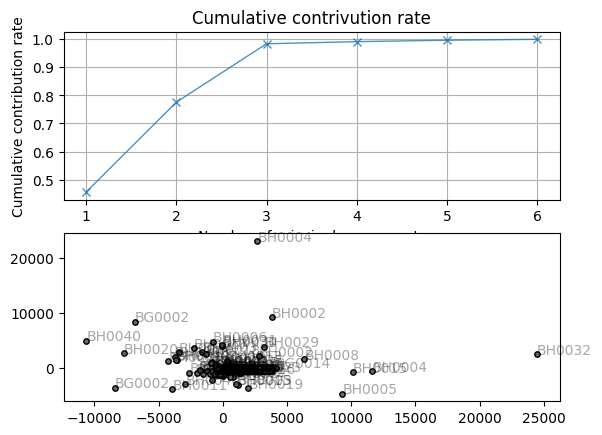

In [ ]:
CROSS_VALID = 0

extrapolated_quad = []

for i in range(extrapolated_pts.shape[0]):
    extrapolated_quad.append(np.append(ex_align_pts[i,:,:].flatten('F'), extrapolated_pt_r[i]))
    # print (extrapolated_quad)
extrapolated_quad = np.array(extrapolated_quad)
print (extrapolated_quad.shape)

for j in [16,26,36]:
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(211)
    ex_pca =PCA(n_components=6)
    if CROSS_VALID == 1:
        ex_quad_train,ex_quad_valid = train_test_split(extrapolated_quad, test_size=0.1, random_state=j)
        ex_result = ex_pca.fit_transform(ex_quad_train)
        ex_valid_result = ex_pca.transform(ex_quad_valid)
    else:
        ex_quad_train = extrapolated_quad
        ex_result = ex_pca.fit_transform(ex_quad_train)
    cumsum = list(np.cumsum(ex_pca.explained_variance_ratio_))
    ax.plot(range(1, len(cumsum)+1),cumsum, "-x",alpha=0.8, linewidth=1)
    #ax.set_xticks([])
    ax.set_xlabel("Number of principal components")
    ax.set_ylabel("Cumulative contribution rate")
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    ax.set_title("Cumulative contrivution rate")
    ax.grid()

    ax2 = fig.add_subplot(212)

    for i in range(len(ex_result)):
        ax2.scatter(ex_result[i,0],ex_result[i,1],
                color = "dimgray", 
                alpha=1, 
                edgecolors="black", 
                linewidths=1, s=15)
        ax2.text(x=ex_result[i,0],y=ex_result[i,1],
            s=files[i].split("\\")[-1].split(".")[0],
            alpha=0.35)
    if CROSS_VALID == 1:
        for i in range(len(ex_valid_result)):
            ax2.scatter(ex_valid_result[i,0],ex_valid_result[i,1],
                    color = "dimgray", 
                    alpha=1, 
                    edgecolors="black", 
                    linewidths=1, s=15, label="test")

    #plt.legend()

# Cubic Spline interpolation + coordinate based PCA

(104, 476)


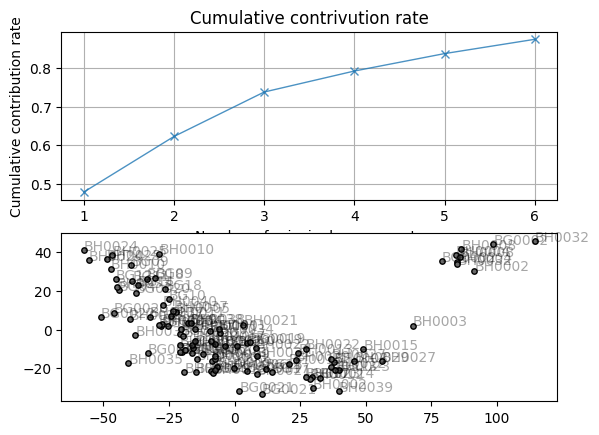

In [ ]:
# print (interpolated_pt_r.shape)
# print (interpolated_pts.shape)

interpolated_quad = []

for i in range(interpolated_pts.shape[0]):
    interpolated_quad.append(np.append(in_align_pts[i,:,:].flatten('F'), interpolated_pt_r[i]))
    # print (extrapolated_quad)
interpolated_quad = np.array(interpolated_quad)
print (interpolated_quad.shape)

for j in [16]:
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(211)
    in_pca =PCA(n_components=6)
    if CROSS_VALID == 1:
        in_quad_train, in_quad_valid = train_test_split(interpolated_quad, test_size=0.1, random_state=j)
        in_result = in_pca.fit_transform(in_quad_train)
        in_valid_result = in_pca.transform(in_quad_valid)
    else: 
        in_quad_train = interpolated_quad
        in_result = in_pca.fit_transform(in_quad_train)
    cumsum = list(np.cumsum(in_pca.explained_variance_ratio_))
    ax.plot(range(1, len(cumsum)+1),cumsum, "-x",alpha=0.8, linewidth=1)
    #ax.set_xticks([])
    ax.set_xlabel("Number of principal components")
    ax.set_ylabel("Cumulative contribution rate")
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    ax.set_title("Cumulative contrivution rate")
    ax.grid()

    ax2 = fig.add_subplot(212)

    for i in range(len(in_result)):
        ax2.scatter(in_result[i,0],in_result[i,1],
                color = "dimgray", 
                alpha=1, 
                edgecolors="black", 
                linewidths=1, s=15)
        ax2.text(x=in_result[i,0],y=in_result[i,1],
            s=files[i].split("\\")[-1].split(".")[0],
            alpha=0.35)
    if CROSS_VALID == 1:
        for i in range(len(in_valid_result)):
            ax2.scatter(in_valid_result[i,0],in_valid_result[i,1],
                    color =  "dimgray", 
                    alpha=1, 
                    edgecolors="black", 
                    linewidths=1, s=15)
        

In [ ]:
r3 = Euclidean(dim=3)
curves_r3 = DiscreteCurves(ambient_manifold=r3)

curve_a, _, _, _, _, ptn_a = GetMyVtk(files[98])
curve_b, _, _, _, _, ptn_b = GetMyVtk(files[26])

cut_len = min(curve_a.shape[0], curve_b.shape[0])
if curve_a.shape[0] > curve_b.shape[0]:
    curve_a = curve_a[:cut_len,:]
elif curve_a.shape[0] < curve_b.shape[0]:
    curve_b = curve_b[:cut_len,:]
print (curve_a.shape)
print (curve_b.shape)

(88, 3)
(88, 3)


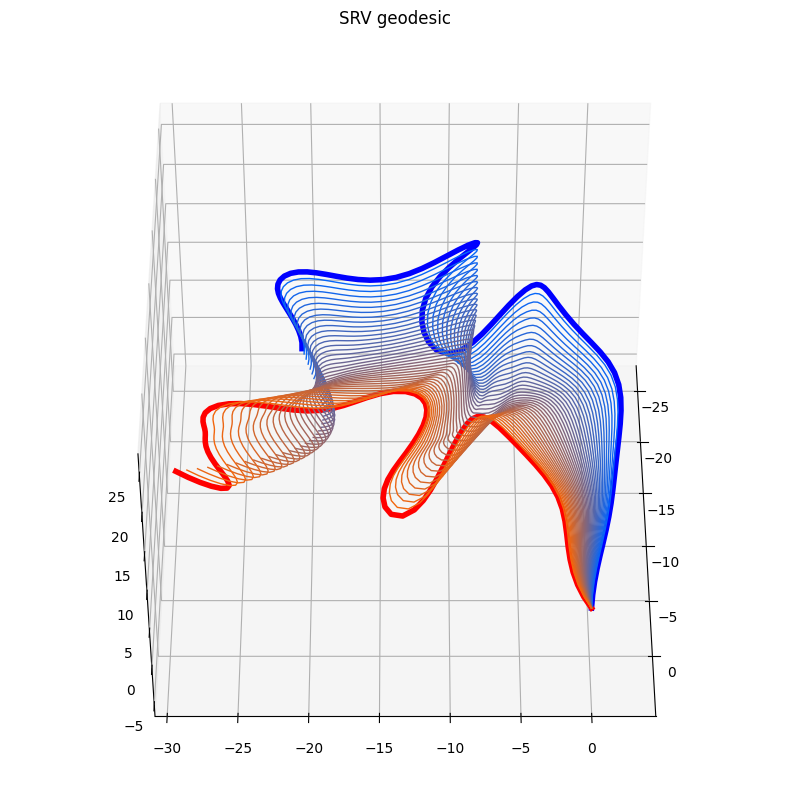

In [ ]:
geod_fun = curves_r3.srv_metric.geodesic(curve_a, curve_b)

n_times = 40
t = gs.linspace(0.0, 1.0, n_times)
geod = geod_fun(t)
v1=45
v2=0
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot(curve_a[:, 0], curve_a[:, 1], curve_a[:, 2], "-", c="b", linewidth=4)
ax.plot(curve_b[:, 0], curve_b[:, 1], curve_b[:, 2], "-", c="r", linewidth=4)
for i in range(1, n_times - 1):
    #print (((i+0.0)/n_times))
    ax.plot(geod[i, :, 0], geod[i, :, 1], geod[i, :, 2], "-", c=[0+((i+0.0)/n_times),0.4,1-((i+0.0)/n_times)], linewidth=1)
    #ax.scatter(geod[i, :, 0], geod[i, :, 1], geod[i, :, 2], c=[0+((i+0.0)/n_times),0,1-((i+0.0)/n_times)], s=8)
# for j in range(cut_len):
    # ax.plot(geod[:, j, 0], geod[:, j, 1], geod[:, j, 2], "-", c="k", alpha=0.3)
ax.view_init(v1, v2)
plt.title("SRV geodesic")
plt.show()

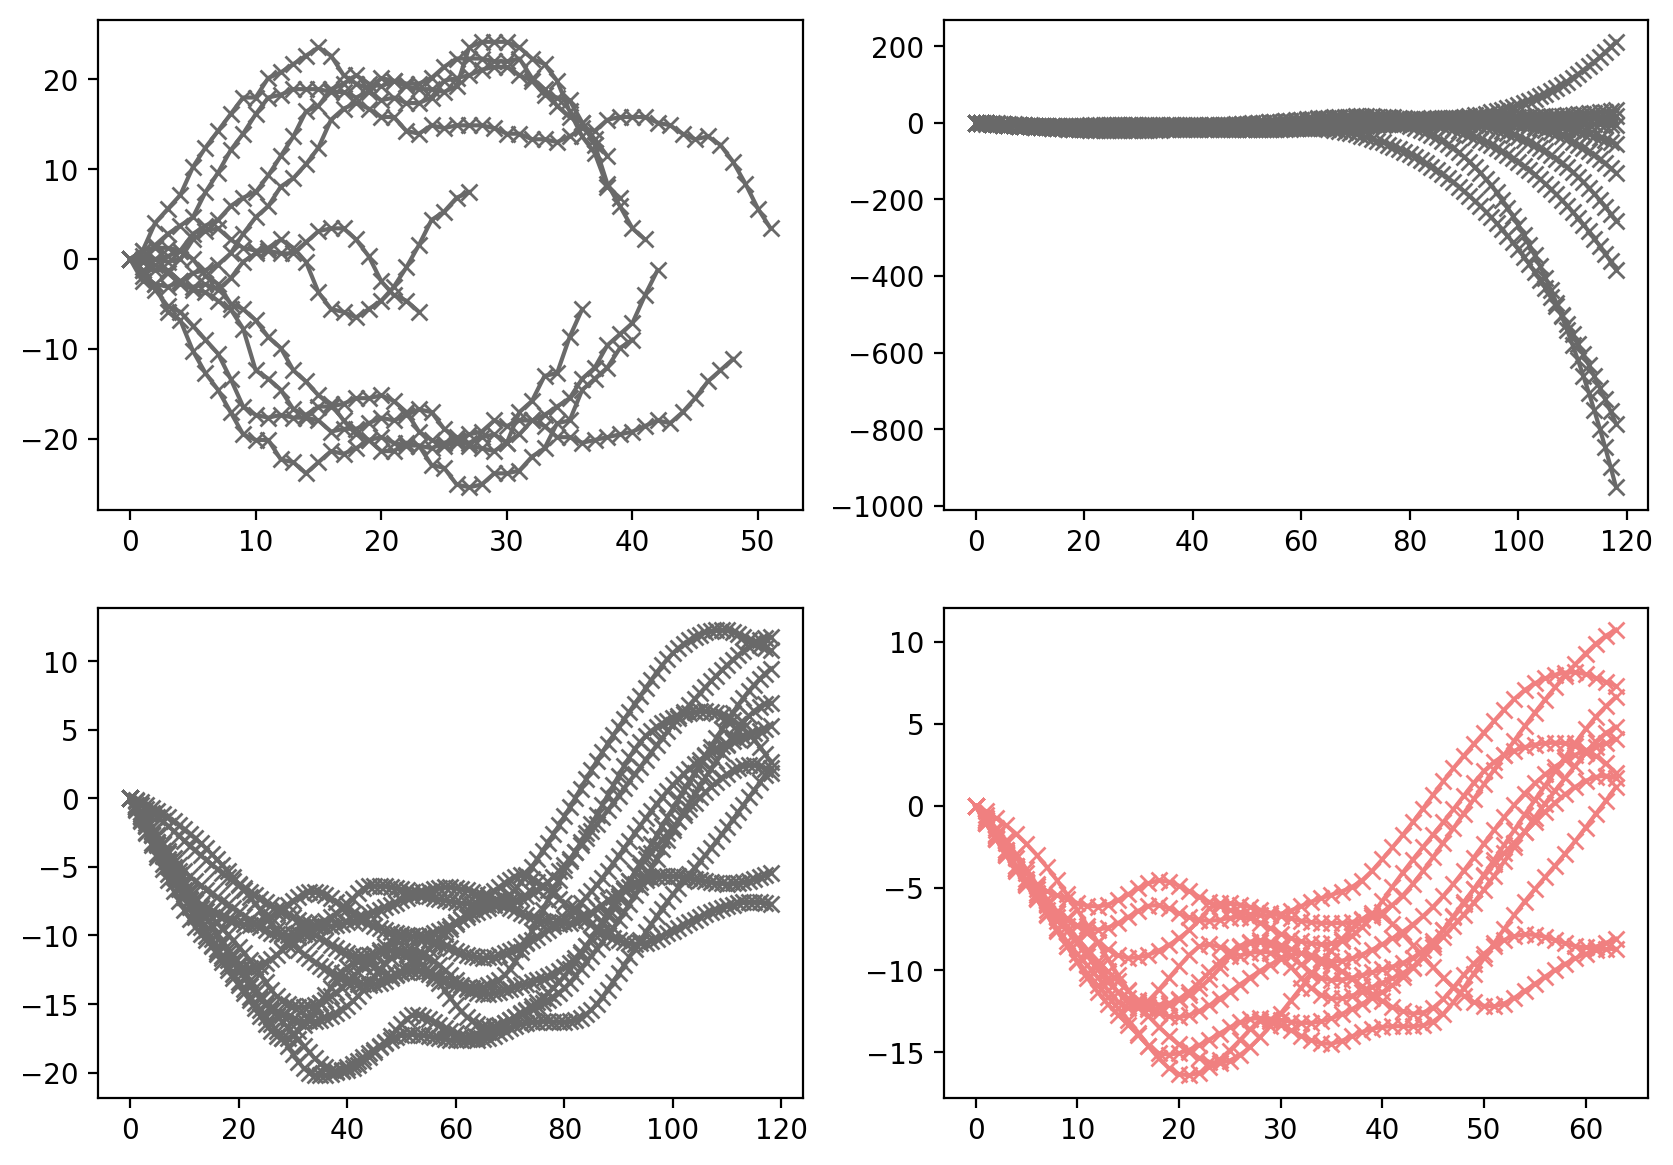

In [ ]:
fig = plt.figure(dpi=200,figsize=(10,7))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

files = glob.glob("D:\\!BraVa_src\\Brava\\major\\*.vtk") 



for j in range(10):
    np_pts, _, _, _, _, _=GetMyVtk(files[j])
    ax.plot(range(len(np_pts[:,0])), np_pts[:,0], marker="x",color="dimgray")
    ax2.plot(range(len(extrapolated_pts[j,:,0])), extrapolated_pts[j,:,0], marker="x",color="dimgray")
    ax3.plot(range(len(interpolated_pts[j,:,0])), interpolated_pts[j,:,0], marker="x",color="dimgray")
    ax4.plot(range(len(scaled_pts[j,:,0])), scaled_pts[j,:,0], marker="x",color="lightcoral")
    
    

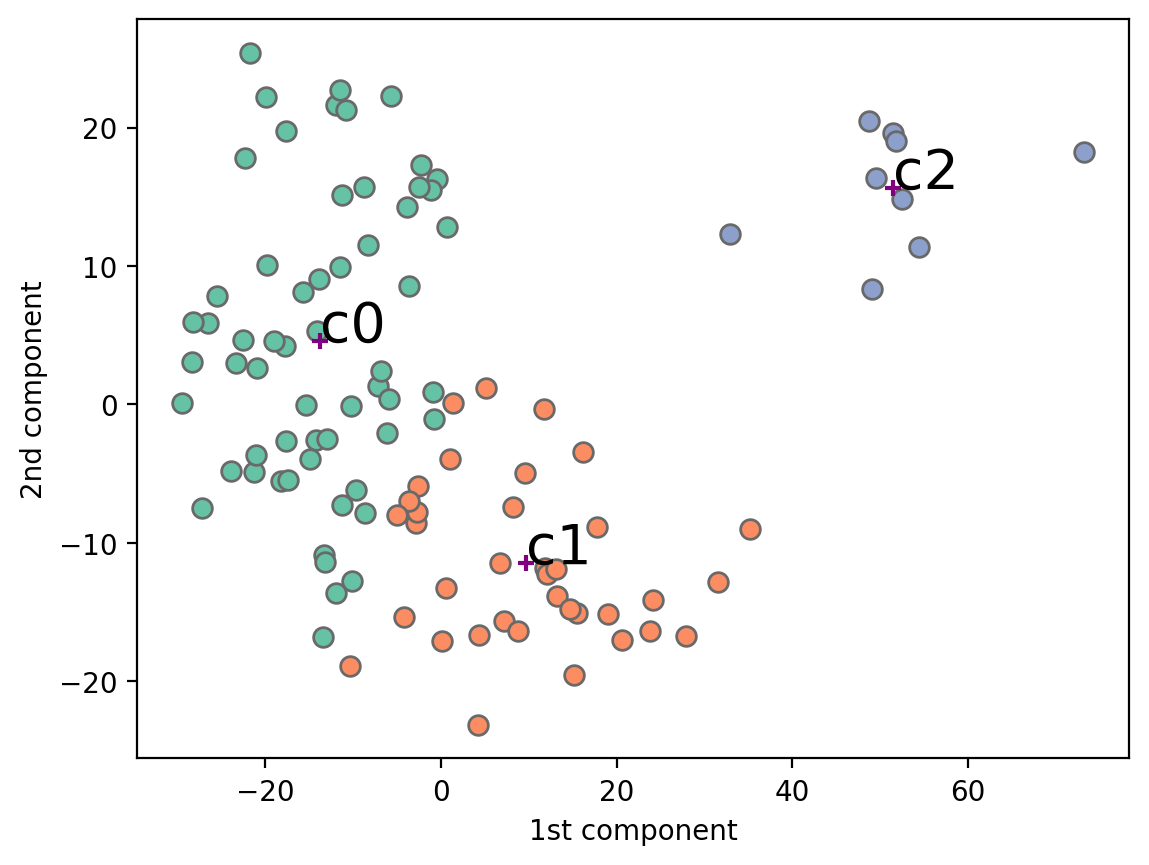

In [17]:
feature = sc_pca.transform(scaled_quad_train)
km = 3
from sklearn.cluster import KMeans   
import seaborn as sns
#colorpalette=np.array(sns.color_palette(palette="Accent", n_colors=3))
colorpalette=np.array(sns.color_palette(palette="Set2", n_colors=km))
colordict = {}
for i in range(km):
    colordict[i]=colorpalette[i]

#{0:colorpalette[0],1:colorpalette[1],2:colorpalette[2]} 

#
"""
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(feature)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()"""


kmeans = KMeans(n_clusters=km)
clusters = kmeans.fit(feature)


fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.set_xlabel("1st component")
ax.set_ylabel("2nd component")
#ax.set_title("k={}".format(km))
#ax.set_xlim((-0.16,0.2))
#ax.set_ylim((-0.15,0.15))
for i in range(len(feature)):
    ax = plt.scatter(feature[i,0],feature[i,1], color=colordict[clusters.labels_[i]], s=50, alpha=1,edgecolors="dimgray")
for i in range(km):
    ax = plt.text(clusters.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], "c{}".format(i), fontsize=20)
#plt.legend()
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='+',label='centroid')

plt.show()

In [30]:
f=open(".\\resampling_weight.csv","w+")
f.write("filename, PC1, PC2, PC3\n")

for i in range(len(scaled_files)):
    f.write("{},{},{},{}\n".format(scaled_files[i].split("\\")[-1], feature[i][0], feature[i][1], feature[i][2]))


print (sc_pca.components_)

for i in range(len(sc_pca.components_)):
    f.write("PC{}:,".format(i+1))
    for j in range(len(sc_pca.components_[i])):
        f.write("{},".format(sc_pca.components_[i][j]))
    f.write("\n")
f.close()




[[ 0.13046246  0.13465387  0.13652818 ... -0.00494855 -0.00571285
  -0.00761746]
 [-0.06629909 -0.06501077 -0.06560221 ...  0.01116701  0.00908848
   0.00706612]
 [ 0.02080676  0.01756822  0.01322093 ... -0.0026587  -0.00361435
  -0.00201945]
 [ 0.02447375  0.02613248  0.03144445 ...  0.00962044  0.00678832
   0.00074577]
 [ 0.06588304  0.06485561  0.06150041 ... -0.00522339 -0.00385221
  -0.00049887]
 [-0.02740816 -0.03077847 -0.0340293  ...  0.00965373  0.01272186
   0.01553662]]


In [85]:
c0 = []
c0r = []
c1 = []
c1r = []
c2 = []
c2r = []

for i in range(len(scaled_pts)):
    if clusters.labels_[i] == 0:
        c0.append(scaled_pts[i])
        c0r.append(scaled_r[i])
    elif clusters.labels_[i] == 1:
        c1.append(scaled_pts[i])
        c1r.append(scaled_r[i])
    elif clusters.labels_[i] == 2:
        c2.append(scaled_pts[i])
        c2r.append(scaled_r[i])

c0 = np.array(c0)
c1 = np.array(c1)
c2 = np.array(c2)
c0r = np.array(c0r)
c1r = np.array(c1r)
c2r = np.array(c2r)


def average_in_cluster(clusterv,axis=2):
    clusterv = np.array(clusterv)
    av = np.zeros(clusterv.shape[1])
    if len(clusterv.shape) > 2:
        for i in range(len(av)):
            av[i] = np.mean(clusterv[:,i,axis])
    else:
        for i in range(len(av)):
            av[i] = np.mean(clusterv[:,i])
    return av



c0_ave = np.zeros_like(c0[0,:,:])
c0_ave[:,0] = average_in_cluster(c0,0)
c0_ave[:,1] = average_in_cluster(c0,1)
c0_ave[:,2] = average_in_cluster(c0,2)
c0r_ave = average_in_cluster(c0r)
c0_scalarattribute = [['MaximumInscribedSphereRadius', 'float',c0r_ave]]

c1_ave = np.zeros_like(c1[0,:,:])
c1_ave[:,0] = average_in_cluster(c1,0)
c1_ave[:,1] = average_in_cluster(c1,1)
c1_ave[:,2] = average_in_cluster(c1,2)
c1r_ave = average_in_cluster(c1r)
c1_scalarattribute = [['MaximumInscribedSphereRadius', 'float',c1r_ave]]

c2_ave = np.zeros_like(c2[0,:,:])
c2_ave[:,0] = average_in_cluster(c2,0)
c2_ave[:,1] = average_in_cluster(c2,1)
c2_ave[:,2] = average_in_cluster(c2,2)
c2r_ave = average_in_cluster(c2r)
c2_scalarattribute = [['MaximumInscribedSphereRadius', 'float',c2r_ave]]

ctotal_scalarattribute = [['MaximumInscribedSphereRadius', 'float',average_in_cluster(scaled_r)]]

#makeVtkFile(coords=c0_ave,scalarAttributes=c0_scalarattribute, savePath=".\\Avg_c0.vtk",fieldAttributes=[])
#makeVtkFile(coords=c1_ave,scalarAttributes=c1_scalarattribute, savePath='.\\Avg_c1.vtk',fieldAttributes=[])
#makeVtkFile(coords=c2_ave,scalarAttributes=c2_scalarattribute, savePath='.\\Avg_c2.vtk',fieldAttributes=[])
#makeVtkFile(coords=scaled_mean_shape,scalarAttributes=ctotal_scalarattribute, savePath='.\\Avg_total.vtk',fieldAttributes=[])

In [84]:
print (scaled_mean_shape.shape)
print (scaled_r.shape)

(64, 3)
(104, 64)
